In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"  # or 2 or 3 depending on what's free

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import os
from transformers import AutoTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, AutoModelForSequenceClassification
import torch
from torch.utils.data import Dataset
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

2025-03-26 15:09:15.123003: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-26 15:09:15.135237: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743001755.149267    7245 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743001755.153569    7245 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743001755.165077    7245 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
# Load dataset
df = pd.read_csv("final_combined_dataset_sentence&emotion_only.csv")

# Label mapping
unique_emotions = df["emotion"].unique()
label2id = {label: idx for idx, label in enumerate(sorted(unique_emotions))}
id2label = {idx: label for label, idx in label2id.items()}

# Apply mapping
df["label"] = df["emotion"].map(label2id)

# Stratified split
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

# Class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df["label"]),
    y=train_df["label"]
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Print for verification
print("Preprocessing complete!")
print(f"Train size: {len(train_df)}")
print(f"Val size: {len(val_df)}")
print("Label2ID:", label2id)
print("Class Weights:", class_weights_dict)

Preprocessing complete!
Train size: 370583
Val size: 92646
Label2ID: {'anger': 0, 'disgust': 1, 'fear': 2, 'happiness': 3, 'neutral': 4, 'sadness': 5, 'surprise': 6}
Class Weights: {0: 0.9845169243194274, 1: 37.81459183673469, 2: 1.3503144562421203, 3: 0.393735012468139, 4: 2.344779368032092, 5: 0.5112596796823587, 6: 3.3892719956100237}


In [4]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased")

# Tokenization function
def tokenize_data(sentences, labels):
    encodings = tokenizer(
        sentences.tolist(),
        padding=True,
        truncation=True,
        max_length=256,
        return_tensors="pt"
    )
    return encodings, torch.tensor(labels.tolist())

# Tokenize train and validation data
train_encodings, train_labels = tokenize_data(train_df["sentence"], train_df["label"])
val_encodings, val_labels = tokenize_data(val_df["sentence"], val_df["label"])

# Custom Dataset class
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Create dataset objects
train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)

print("Tokenization complete. Ready for training.")


Tokenization complete. Ready for training.


In [5]:
# Load model
model = BertForSequenceClassification.from_pretrained(
    "bert-large-uncased",
    num_labels=7,
    id2label=id2label,
    label2id=label2id
)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Convert class weights to tensor
weights = torch.tensor(list(class_weights_dict.values()), dtype=torch.float).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=weights)

# Custom compute_metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {"macro_f1": f1, "accuracy": acc}

training_args = TrainingArguments(
    output_dir="checkpoints",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    save_total_limit=2,
    num_train_epochs=5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    report_to="none",
    fp16=True
)



# Trainer with custom loss function
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss


# Initialize trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [6]:
# Train the model
trainer.train()

Step,Training Loss


TrainOutput(global_step=34743, training_loss=0.43889191707682124, metrics={'train_runtime': 7882.6538, 'train_samples_per_second': 141.037, 'train_steps_per_second': 4.408, 'total_flos': 5.1804563231239834e+17, 'train_loss': 0.43889191707682124, 'epoch': 3.0})

In [7]:
trainer.save_model("bert_large_2")
tokenizer.save_pretrained("bert_large_2")

('bert_large_2/tokenizer_config.json',
 'bert_large_2/special_tokens_map.json',
 'bert_large_2/vocab.txt',
 'bert_large_2/added_tokens.json',
 'bert_large_2/tokenizer.json')

Classification Report:
              precision    recall  f1-score   support

       anger       0.57      0.29      0.39       217
     disgust       1.00      0.50      0.67         2
        fear       0.50      0.17      0.25        42
   happiness       0.67      0.30      0.42       184
     neutral       0.41      0.83      0.55       327
     sadness       0.57      0.17      0.27       144
    surprise       0.28      0.28      0.28        25

    accuracy                           0.46       941
   macro avg       0.57      0.36      0.40       941
weighted avg       0.52      0.46      0.42       941



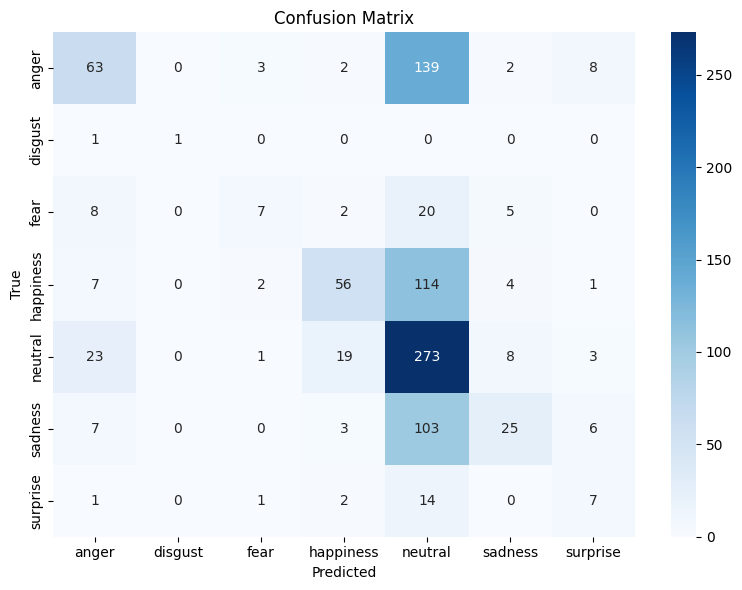

In [2]:
# Emotion mapping provided by teacher
emotion_mapping = {
    "happiness": [
        "joy", "optimism", "approval", "pride", "gratitude", "confidence",
        "satisfaction", "hope", "love", "excitement", "caring", "relief", "admiration",
        "amusement", "anticipation", "encouragement", "desire", "happiness"
    ],
    "sadness": [
        "disappointment", "nostalgia", "remorse", "pain", "stress", "regret",
        "resignation", "despair", "confusion", "uncertainty", "sadness"
    ],
    "anger": [
        "anger", "annoyance", "disapproval", "frustration", "disbelief", "warning",
        "rejection"
    ],
    "disgust": ["disgust"],
    "fear": [
        "fear", "nervousness", "worry", "anxiety", "doubt", "insecurity", "urgency",
        "panic"
    ],
    "surprise": ["surprise", "realization", "shock", "amazement", "wonder"],
    "neutral": [
        "neutral", "mixed", "trust", "agreement", "instruction", "suggestion",
        "request", "confirmation", "acceptance", "reassurance", "clarification",
        "understanding", "certainty"
    ]
}

# Reverse the mapping for fast lookup
reverse_mapping = {sub: main for main, subs in emotion_mapping.items() for sub in subs}

# Load test data
df = pd.read_excel("group 24_url1.xlsx")

# Apply mapping
df["Mapped_Emotion"] = df["Emotion"].map(reverse_mapping)

# Drop rows with unmapped emotions (should be none if clean)
df = df.dropna(subset=["Mapped_Emotion"])

# Define label2id and id2label
core_emotions = ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
label2id = {label: i for i, label in enumerate(core_emotions)}
id2label = {i: label for label, i in label2id.items()}

# Convert mapped emotion to numeric labels
df["label"] = df["Mapped_Emotion"].map(label2id)

# Tokenize
tokenizer = AutoTokenizer.from_pretrained("bert_large_2")
encodings = tokenizer(
    df["Translation"].tolist(),
    truncation=True,
    padding=True,
    max_length=256,
    return_tensors="pt"
)

# Dataset wrapper
class EmotionTestDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels)

    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

test_dataset = EmotionTestDataset(encodings, df["label"].tolist())

# Load trained model
model = AutoModelForSequenceClassification.from_pretrained("bert_large_2")

# Predict
trainer = Trainer(model=model)
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = df["label"].tolist()

# Evaluation
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=core_emotions))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=core_emotions,
            yticklabels=core_emotions)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [3]:
# Macro F1: unweighted mean across all classes
macro_f1 = f1_score(y_true, y_pred, average="macro")
print("F1-score:", round(macro_f1, 4))

F1-score: 0.4025


In [4]:
# Macro F1: unweighted mean across all classes
macro_f1 = f1_score(y_true, y_pred, average="weighted")
print("F1-score:", round(macro_f1, 4))

F1-score: 0.4229
